In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [5]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/segmentation/'
model_path = model_base_path + '63-unet_efficientnetb0_320x480_(fish).h5'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_path = 'train_images/'

### Load data

In [8]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['Class'] = train['Image_Label'].apply(lambda x: x.split('_')[1])

# Only fish images
train = train[train['Class'] == 'Fish']

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [0]:
BACKBONE = 'efficientnetb0'
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 1
label_columns=['Fish']

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
segmentation_model = load_model(model_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Segmentation threshold and mask size tunning

In [13]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
threshold_grid = np.arange(0, 1, .05)
best_treshold_seg, best_mask_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=300)

Fish treshold=0.40 mask size=20000 Dice=0.624


### Non-empty masks

In [14]:
best_treshold_seg2, best_mask_seg2 = segmentation_tunning_single_class(segmentation_model, train, X_val[X_val['Fish'] == 1], train_images_path, (HEIGHT, WIDTH), label_columns, mask_grid, threshold_grid, preprocessing, seed, batch_size=300)

Treshold=0.05 mask size=0 Dice=0.581


# Model evaluation

In [16]:
print('Full set')
get_metrics_single_class(segmentation_model, train, X_train, train_images_path, (HEIGHT, WIDTH), best_treshold_seg[0], best_mask_seg[0], seed=seed, preprocessing=preprocessing, batch_size=300)
get_metrics_single_class(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), best_treshold_seg[0], best_mask_seg[0], seed=seed, preprocessing=preprocessing, batch_size=300)

Dice 0.468 Dice post 0.677
Dice 0.570 Dice post 0.580


In [19]:
print('Non-empty set')
get_metrics_single_class(segmentation_model, train, X_train[X_train['Fish'] == 1], train_images_path, (HEIGHT, WIDTH), best_treshold_seg[0], best_mask_seg[0], seed=seed, preprocessing=preprocessing, batch_size=300)
get_metrics_single_class(segmentation_model, train, X_val[X_val['Fish'] == 1], train_images_path, (HEIGHT, WIDTH), best_treshold_seg[0], best_mask_seg[0], seed=seed, preprocessing=preprocessing, batch_size=300)

Dice 0.593 Dice post 0.543
Dice 0.588 Dice post 0.595


### Non-empty masks parameters

In [17]:
print('Full set')
get_metrics_single_class(segmentation_model, train, X_train, train_images_path, (HEIGHT, WIDTH), best_treshold_seg2, best_mask_seg2, seed=seed, preprocessing=preprocessing, batch_size=300)
get_metrics_single_class(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), best_treshold_seg2, best_mask_seg2, seed=seed, preprocessing=preprocessing, batch_size=300)

Dice 0.468 Dice post 0.330
Dice 0.570 Dice post 0.150


In [18]:
print('Non-empty set')
get_metrics_single_class(segmentation_model, train, X_train[X_train['Fish'] == 1], train_images_path, (HEIGHT, WIDTH), best_treshold_seg2, best_mask_seg2, seed=seed, preprocessing=preprocessing, batch_size=300)
get_metrics_single_class(segmentation_model, train, X_val[X_val['Fish'] == 1], train_images_path, (HEIGHT, WIDTH), best_treshold_seg2, best_mask_seg2, seed=seed, preprocessing=preprocessing, batch_size=300)

Dice 0.593 Dice post 0.691
Dice 0.588 Dice post 0.677


## Inspecting some of the validation set predictions

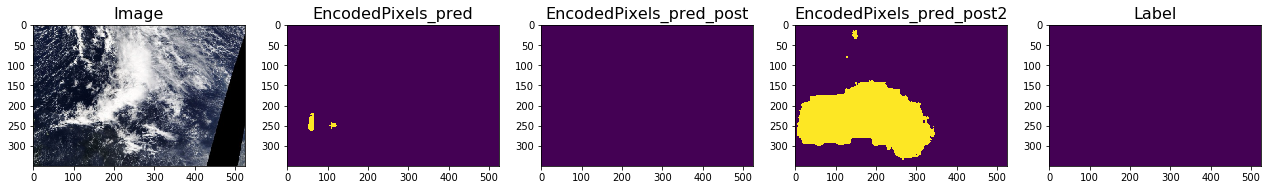

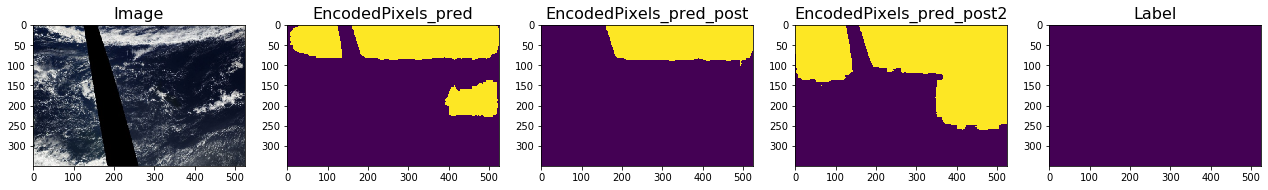

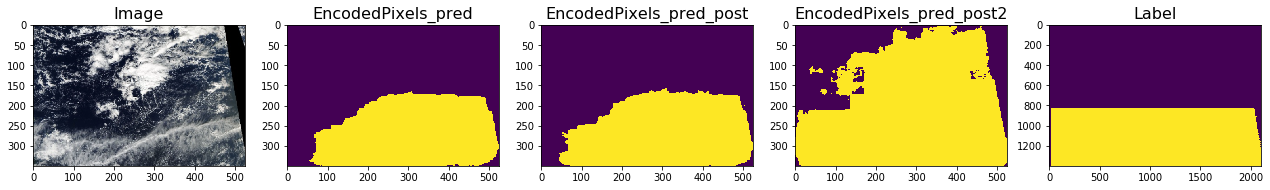

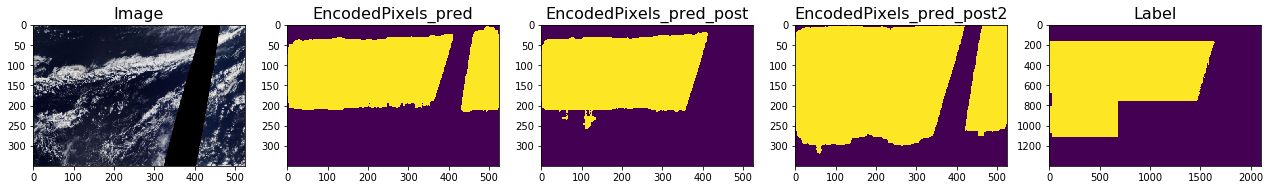

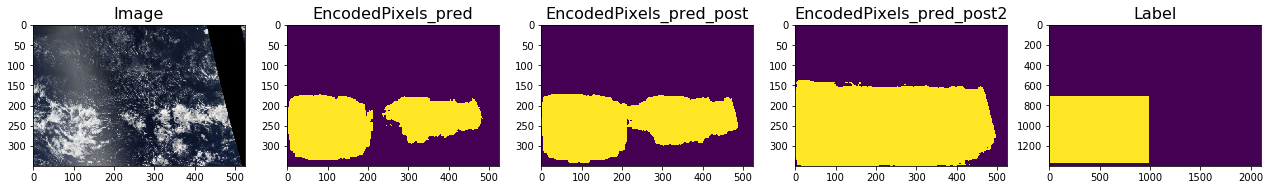

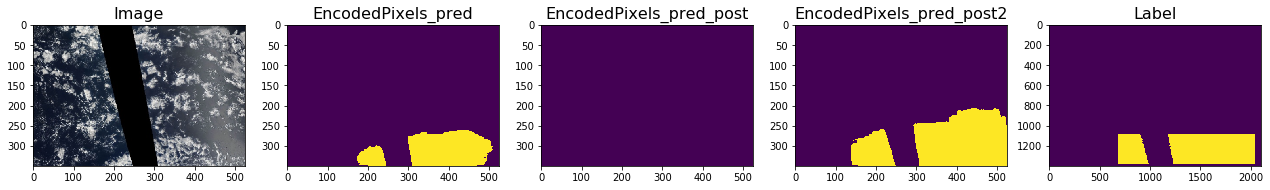

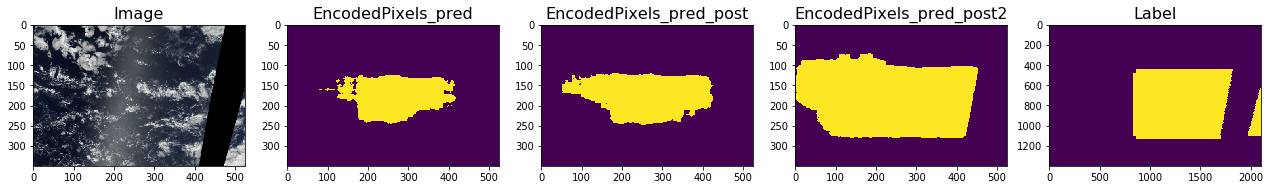

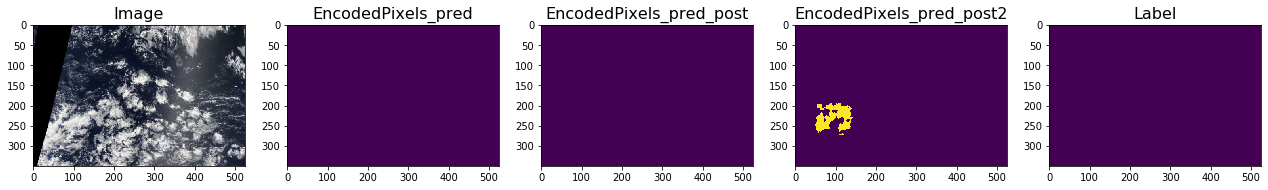

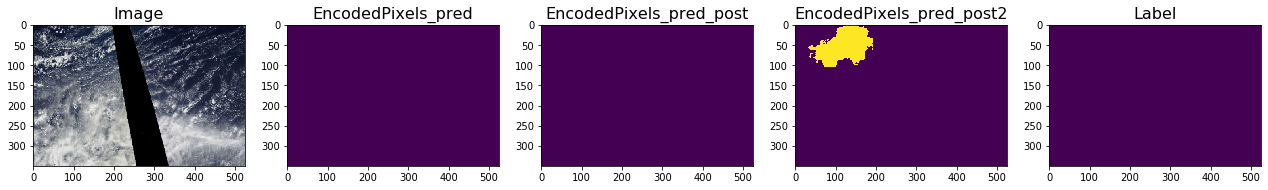

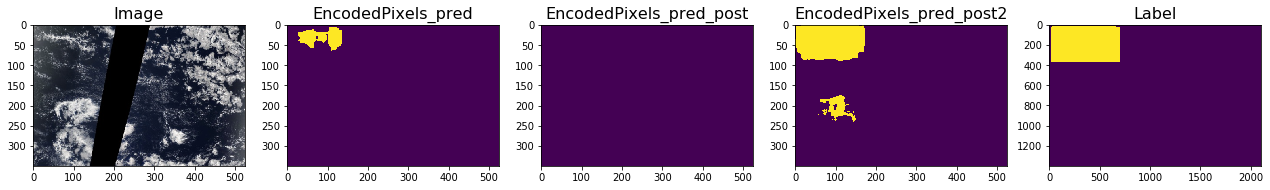

In [63]:
#@title
images_to_inspect = np.random.choice(X_val['image'].unique(), 10, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_class = X_val[X_val['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_mask = preds[index].astype('float32')
    ### Raw parameters
    pred_mask_clean = post_process(pred_mask, threshold=.5, min_size=0)
    pred_rles = build_rles(pred_mask_clean, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    ### Post procecssing
    pred_mask_post = post_process(pred_mask, threshold=best_treshold_seg[0], min_size=best_mask_seg[0])
    pred_rles_post = build_rles(pred_mask_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ### Post procecssing non-empty
    pred_mask_post2 = post_process(pred_mask, threshold=best_treshold_seg2, min_size=best_mask_seg2)
    pred_rles_post2 = build_rles(pred_mask_post2, reshape=(350, 525))
    image_df['EncodedPixels_pred_post2'] = pred_rles_post2
    
    inspect_set_temp.append(image_df)

inspect_set = pd.concat(inspect_set_temp)
inspect_predictions_single_class(inspect_set, train_images_path, pred_cols=['EncodedPixels_pred', 'EncodedPixels_pred_post', 'EncodedPixels_pred_post2'])